# Group Project
### Members:
- Minh Au
- Andrew Carriere
- Veronika Bumbulovic
- Kevin Yoon Jeong

## 1. Introduction
Heart disease is the second leading cause of death in Canada after cancer(Public Health Agency of Canada, 2018). The cause of heart disease is multifactorial and has been linked to smoking, dyslipidemia, hypertension, diabetes, obesity, and lifestyle (Lopez, 2022). Heart disease refers to the following 4 pathologies (Lopez, 2022):

- Coronary heart disease (CHD): Caused by ischemia (lack of oxygen perfusion) of myocardial tissues resulting in angina, myocardial infarction and/or heart failure.
- Cerebrovascular diseases: This includes stroke and transient ischemic attack.
- Peripheral artery disease (PAD): Arterial disease occurring in peripheral tissues causing ischemia.
- Aortic arteriosclerosis: Narrowing and stiffening of aorta that can result in aneurysm. 

In this project, we will attempt to answer the following question. Using readily-available data, how accurately can we pre-diagnose a heart condition? If successful, this could have significant implications in patient outcomes by decreasing the time before treatment. The dataset was sourced from the UC Irvine Machine Learning Repository, and Andras Janosi, M.D., at the Hungarian Institute of Cardiology. 


## 1.2 Preliminary exploratory data analysis
The following two cells will load the necessary libraries and read the data, which is essential as the first step for the analysis.

In [1]:
#loading necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(patchwork)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Data from Hungary, Long Beach, and Switzerland will be combined into one to populate the dataset. We excluded the data from Cleveland because the README states the data file is corrupted.

In [2]:
# Reading the data
hungarian_heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/hungarian.data", col_names = FALSE)
longbeach_heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/long-beach-va.data", col_names = FALSE)
switzerland_heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/switzerland.data", col_names = FALSE)
# Combine multiple data sets into one
heart_data <- rbind(hungarian_heart_data, longbeach_heart_data) |>
    rbind(switzerland_heart_data)
head(heart_data, 10)

Rows: 2940 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2000 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1230 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1
<chr>
1254 0 40 1 1 0 0
-9 2 140 0 289 -9 -9 -9
0 -9 -9 0 12 16 84 0
0 0 0 0 150 18 -9 7
172 86 200 110 140 86 0 0
0 -9 26 20 -9 -9 -9 -9
-9 -9 -9 -9 -9 -9 -9 12
20 84 0 -9 -9 -9 -9 -9
-9 -9 -9 -9 -9 1 1 1


As seen in the small subset above, the data is not in a tidy format, thus, is not ready for analysis. We know there are 76 attributes from the documentation, but they are currently grouped in one column. Furthermore, the 76 attributes are spread across ten different lines with a different number of attributes on each line (some with 8 while the others only have 7). As such, the data-wrangling strategy is as follows:

    1. Combine the 76 attributes into one row. They must be separated by a delimiter such as ",".
    2. Each row is separated into multiple columns.
    3. Load the names of the attributes
    4. Select the following factors as described in the method section and convert them into the correct type
         - age - age in years
         - sex - 0 for female, 1 for male
         - chol - serum cholesterol in mg/dl
         - cigs - cigarettes per day
         - years - number of years as a smoker
         - thalach - maximum heart rate achieved
         - thalrest - resting heart rate
         - trestbpd - resting blood pressure
         - num - diagnosis of heart disease (0 for absence, 1 - 4 for present)


In [3]:
# Separate the data with commas
separated_with_commas <- heart_data |>
    separate(col = X1, into = c("X1", "X2", "X3", "X4", "X6", "X7", "X8", "X9"), sep = " ") |>
    rowwise() |>
    mutate(combined_col = paste0(str_replace_na(c_across(X1:X9), replacement = ""), collapse = ",")) |>
    ungroup() |>
    select(combined_col)

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 1234 rows [1, 10, 11, 20, 21, 30, 31, 40, 41, 50, 51, 60, 61, 70, 71, 80, 81, 90, 91, 100, ...].”


In [4]:
# Combine rows and split columns before assigning names
clean_data <- separated_with_commas |>
    mutate(num = ceiling(row_number() / 10)) |>
    group_by(num) |>
    summarise(combined_col = gsub(',,', ',', gsub('NA', '', paste0(combined_col, collapse = ",")))) |>
    ungroup() |>
    separate(col = combined_col, into = c('id', 'ccf', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp', 'trestbps', 'htn', 'chol', 'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'diuretic', 'proto', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo', 'cday', 'cyr', 'num', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name'), sep = ",")
head(clean_data, 1)
# Convert the types of the data and select desired factors
processed_heart_data <- clean_data |>
    select(age, sex, chol, cigs, years, thalach, thalrest, trestbpd, num) |>
    mutate(age = as.numeric(age), sex = as.numeric(sex), chol = as.numeric(chol), cigs = as.numeric(cigs), 
          years = as.numeric(years), thalach = as.numeric(thalach), thalrest = as.numeric(thalrest), 
           trestbpd = as.numeric(trestbpd), num = as.numeric(num))
head(processed_heart_data, 5)

Warning message:
“Expected 76 pieces. Additional pieces discarded in 617 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,⋯,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1254,0,40,1,1,0,0,-9,2,140,⋯,-9,-9,1,1,1,1,1,-9.,-9.,name


age,sex,chol,cigs,years,thalach,thalrest,trestbpd,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40,1,289,-9,-9,172,86,86,0
49,0,180,-9,-9,156,100,90,1
37,1,283,-9,-9,98,58,80,0
48,0,214,-9,-9,108,54,86,3
54,1,-9,-9,-9,122,74,90,0


Note that sex is not converted into a factor because the model can only classify using numeric predictors. Having sex as numeric will not affect the scaling or the training in any detrimental way because it is a simple binary category. <br>
Most of the smoking data is missing (-9 represents missing data), so it cannot be used for training the model. <br>
Also, a heart disease diagnosis is a binary category since it's either present or absent. So it's represented as 0 and 1 being the absence or presence of the heart disease, respectively. For clarity, let the column name be "diagnosis." <br>


In [5]:
# Remove unwanted factors and add NA
final_heart_data <- processed_heart_data |>
    mutate(diagnosis = 1 * (num >= 1)) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    select(-cigs, -years, -num)
final_heart_data[final_heart_data == -9] <- NA
final_heart_data <- final_heart_data |>
    drop_na()
head(final_heart_data)

age,sex,chol,thalach,thalrest,trestbpd,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,1,289,172,86,86,0
49,0,180,156,100,90,1
37,1,283,98,58,80,0
48,0,214,108,54,86,1
39,1,339,170,86,80,0
45,0,237,170,90,84,0


As a result, the table above shows a subset of the wrangled data. Now, we can split the data into training and testing sets to begin the analysis. Since there are 531 rows, 80% of the dataset will give us approximately 430 observations, which is suitable for training the model. Therefore, the proportion between training and testing data will be 80%.

In [6]:
# Splitting the data into training and testing
set.seed(1337) # Set seed for reproducility
heart_split <- initial_split(final_heart_data, prop = 0.8, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing (heart_split)

Now, let's examine the training set for more information about the data. One valuable data is the number of observations with and without heart disease.

In [7]:
# Summarize the training data
heart_train |>
    group_by(diagnosis) |>
    summarize(count = n())

diagnosis,count
<fct>,<int>
0,167
1,257


As seen in the summary table, the number of people with heart disease differs from those without by approximately 100 people, which, considering the training set size, is significant. Thus, it will be considered when the actual classification is done.

Calculating the means after grouping by the presence of heart disease and sex will highlight the difference between the two sex in the context of heart diseases.

In [8]:
# Summarize the training data
heart_train |>
    group_by(diagnosis, sex) |>
    summarise(count = n(), mean_age = mean(age, na.rm = TRUE), mean_chol = mean(chol, na.rm = TRUE),
             mean_thalach = mean(thalach, na.rm = TRUE), mean_thalrest = mean(thalrest, na.rm = TRUE),
             mean_trestbpd = mean(trestbpd, na.rm = TRUE))

`summarise()` has grouped output by 'diagnosis'. You can override using the
`.groups` argument.


diagnosis,sex,count,mean_age,mean_chol,mean_thalach,mean_thalrest,mean_trestbpd
<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,53,47.81132,245.6981,142.3019,81.00000,82.01887
0,1,114,48.60526,203.1404,141.7018,80.42982,83.86842
1,0,16,54.50000,176.7500,131.2500,85.62500,86.37500
1,1,241,55.37344,135.6680,123.0830,71.80913,82.65560


It could be seen that more men have heart diseases than women by looking at the table. Moreover, it generally requires women to have higher health statistics to have heart conditions (except for age). According to the mean for both sexes, people with heart disease are usually older than those without.

## 1.3 Visualization of Preliminary exploratory data

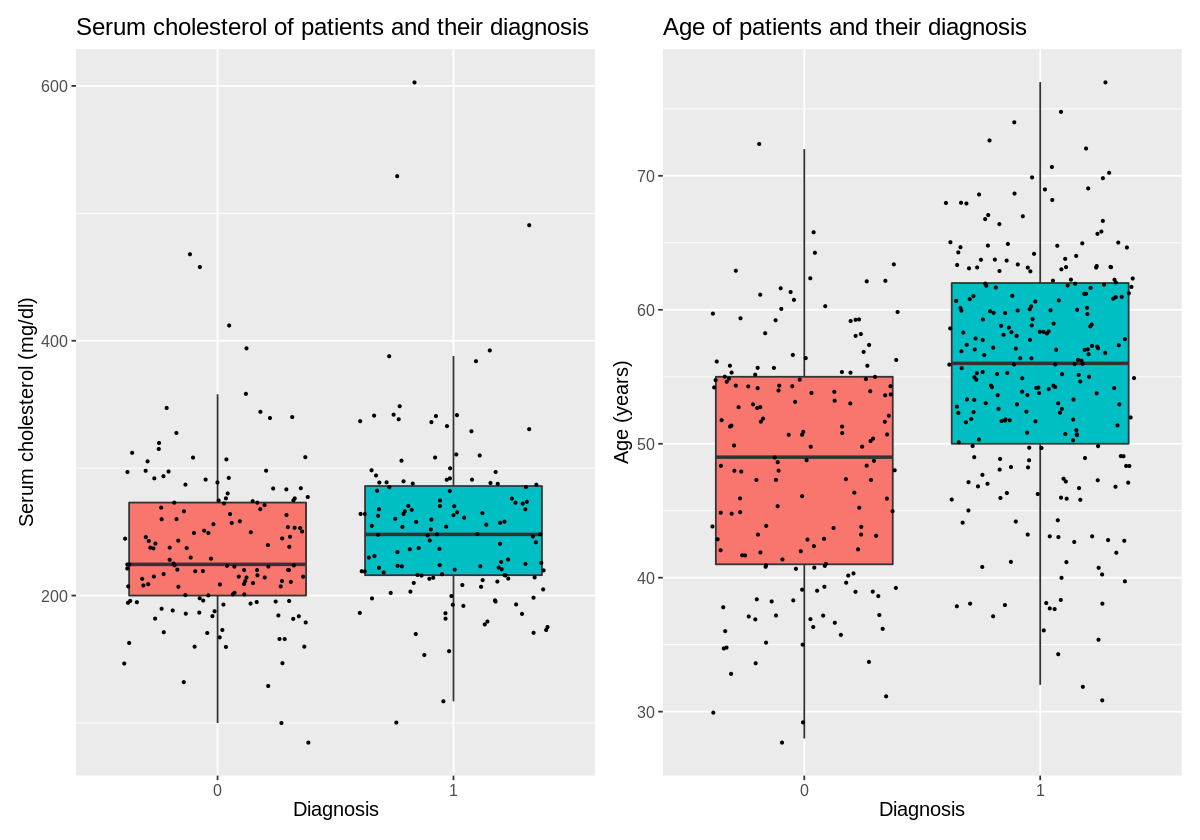

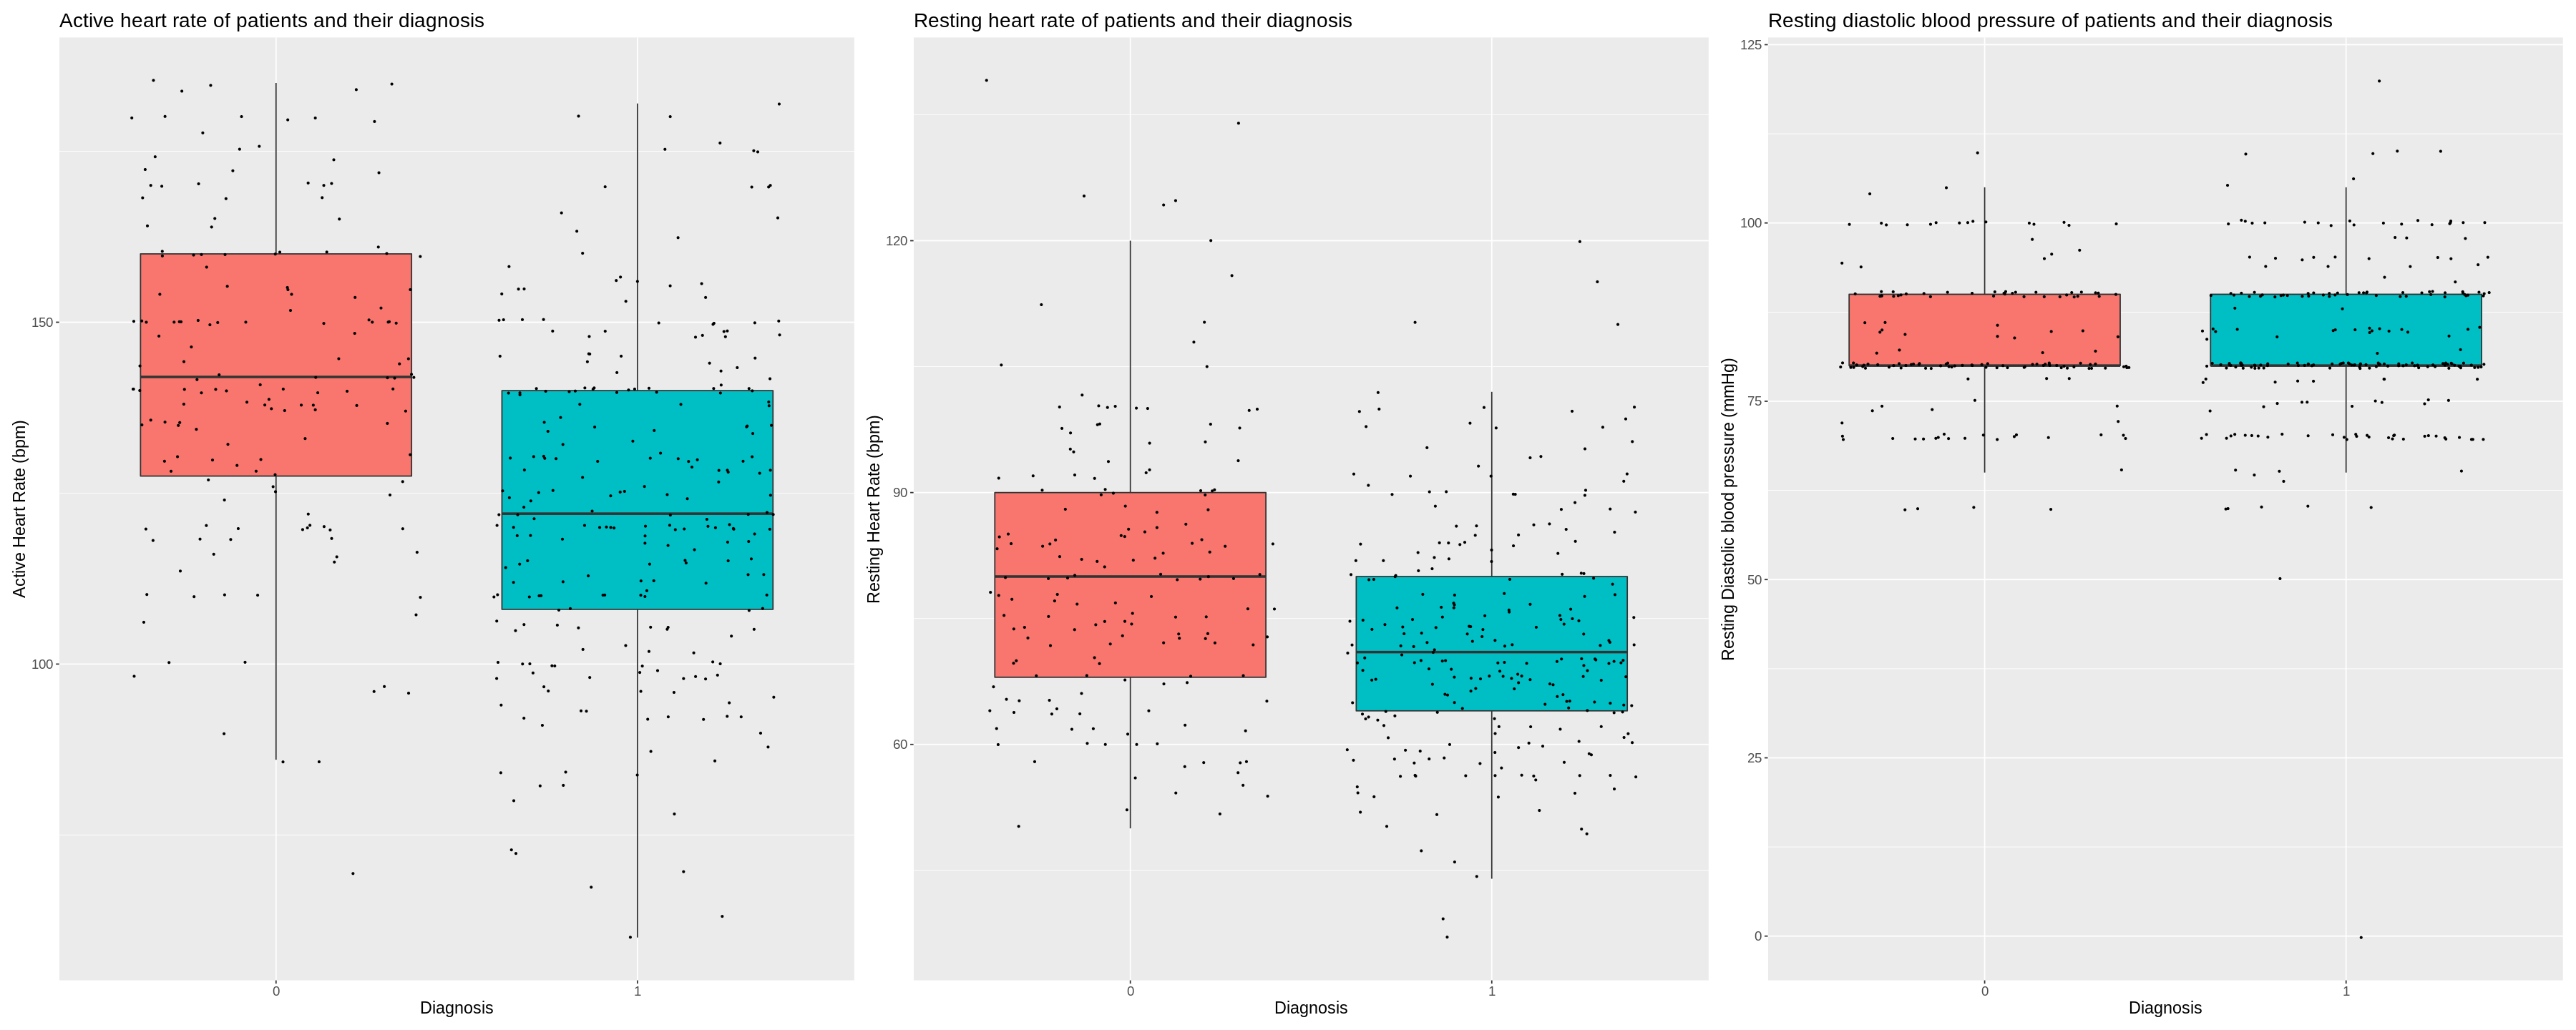

In [20]:
# Serum cholesterol box plot vs diagnosis
chol_plot <- heart_train |>
    filter(chol != 0) |>
    ggplot(aes(x = diagnosis, y = chol, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Serum cholesterol of patients and their diagnosis") +
        ylab("Serum cholesterol (mg/dl)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12)) 

# age box plot vs diagnosis
age_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = age, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Age of patients and their diagnosis") +
        ylab("Age (years)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 12))

# Active heart rate(bpm) box plot vs diagnosis
thalach_plot <- heart_train |>
    filter(thalach > 0) |>
    ggplot(aes(x = diagnosis, y = thalach, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Active heart rate of patients and their diagnosis") +
        ylab("Active Heart Rate (bpm)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 14)) 

# Resting heart rate(bpm) box plot vs diagnosis
thalrest_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = thalrest, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Resting heart rate of patients and their diagnosis") +
        ylab("Resting Heart Rate (bpm)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 14)) 

# Resting diastolic blood pressure (mmHg) box plot vs diagnosis
trestbpd_plot <- heart_train |>
    ggplot(aes(x = diagnosis, y = trestbpd, fill = diagnosis)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(color = "black", size = 0.5) +
        ggtitle("Resting diastolic blood pressure of patients and their diagnosis") +
        ylab("Resting Diastolic blood pressure (mmHg)") +
        xlab("Diagnosis") +
        theme(legend.position = 'none',
             text = element_text(size = 14)) 


options(repr.plot.width=10, repr.plot.height=7)
chol_plot + age_plot + plot_layout(widths = c(100, 100))
options(repr.plot.width=30, repr.plot.height=12)
thalach_plot + thalrest_plot + trestbpd_plot + plot_layout(widths = c(10, 10, 10))

People diagnosed with a heart condition have a higher mean age and cholesterol mean readings than those without, as seen in the box plot above. On the other hand, it's surprising that those with a heart condition have an average lower active and resting heart rate. The mean blood pressure for both groups of people is similar, which contradicts what we expected. Except for the blood pressure graph, the data points are decently spread out as indicated visually and the expanded height of the box plots. This characteristic of the dataset will be taken into account during the data analysis.

## 2. Methods
   We aim to create a highly accurate classification model using the factors that are easily measurable and significantly affect heart disease. These factors were previously determined to be age, cholesterol, max heart rate, resting heart rate, and resting blood pressure. However, typically the best models are selective with which variables are used to avoid noise in the data, meaning the best model probably wouldn’t use all five variables. So, we must create multiple models and compare their accuracy in the validation set to determine which is best. We decided first to create a model that uses all five factors as a point of comparison. The second model excluded the factor with the lowest correlation to heart disease. The decision on the amount of correlation between heart disease and the variable was made by examining if there was a lot of overlap of the IQR* boxes or if neither median is above or below the IQR box of the other diagnosis, which would indicate a weak correlation. Models would be systematically made by excluding the least correlated factor from the previous model until a model worse than the first is created. The most accurate model is chosen.
   
*IQR= Interquartile Range, lower line of box is 25th percentile, upper line of box is 75th percentile.


## 2.1 Classification Model

   The tested K values were determined by trial and error to balance accuracy and speed. It was ensured that beyond the K range, it was impossible to have a highly accurate K value by looking at the K  value graph. The range ends where the model begins to overfit and underfit. Since this is a large dataset, the K value would need to be relatively large; however, not big enough to see a large percentage of the data to begin underfitting. The interval between tested K values was ensured to be far enough to avoid repeating accuracy values and wasting time. We also decided all tested K values should be odd numbers since even numbers can lead to ties between classifications. 

In [40]:
set.seed(1337) # Set seed for reproducility

#creating recipe for model with all predictors
all_recipe <- recipe(diagnosis ~ age + chol + thalach + thalrest + trestbpd, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#knn model with unknown K
all_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating validation set and K values
all_heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)
all_k_vals <- tibble(neighbors = seq(from = 31, to = 61, by = 4))

#applying model to validation sets
all_knn_results <- workflow() |>
    add_recipe(all_recipe) |>
    add_model(all_knn_spec) |>
    tune_grid(resamples = all_heart_vfold, grid = all_k_vals) |>
    collect_metrics()

#Getting K values accuracy
all_accuracy <- all_knn_results |>
    filter(.metric == "accuracy")

#Filtering for most accurate K value
all_kvalue <- all_accuracy |> filter(mean == max(mean)) 

#pulling the two values we want: the most accurate K and it's accuracy
pull(all_kvalue, neighbors)
pull(all_kvalue, mean)


[1] 47

[1] 0.7570875

In [11]:
#creating function to optain K accuracy plot
getKPlot <- function(accuracy_df) {
    plot <- accuracy_df |>
        ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "K values", y = "Accuracy (in %)") +
        ggtitle("Accuracy vs. K values") +
        theme(text = element_text(size = 25))
    return(plot)
}

To prevent code repetition, the function `getKPlot()` is defined to make a plot of Accuracy vs. K-values for a given accuracy data frame.

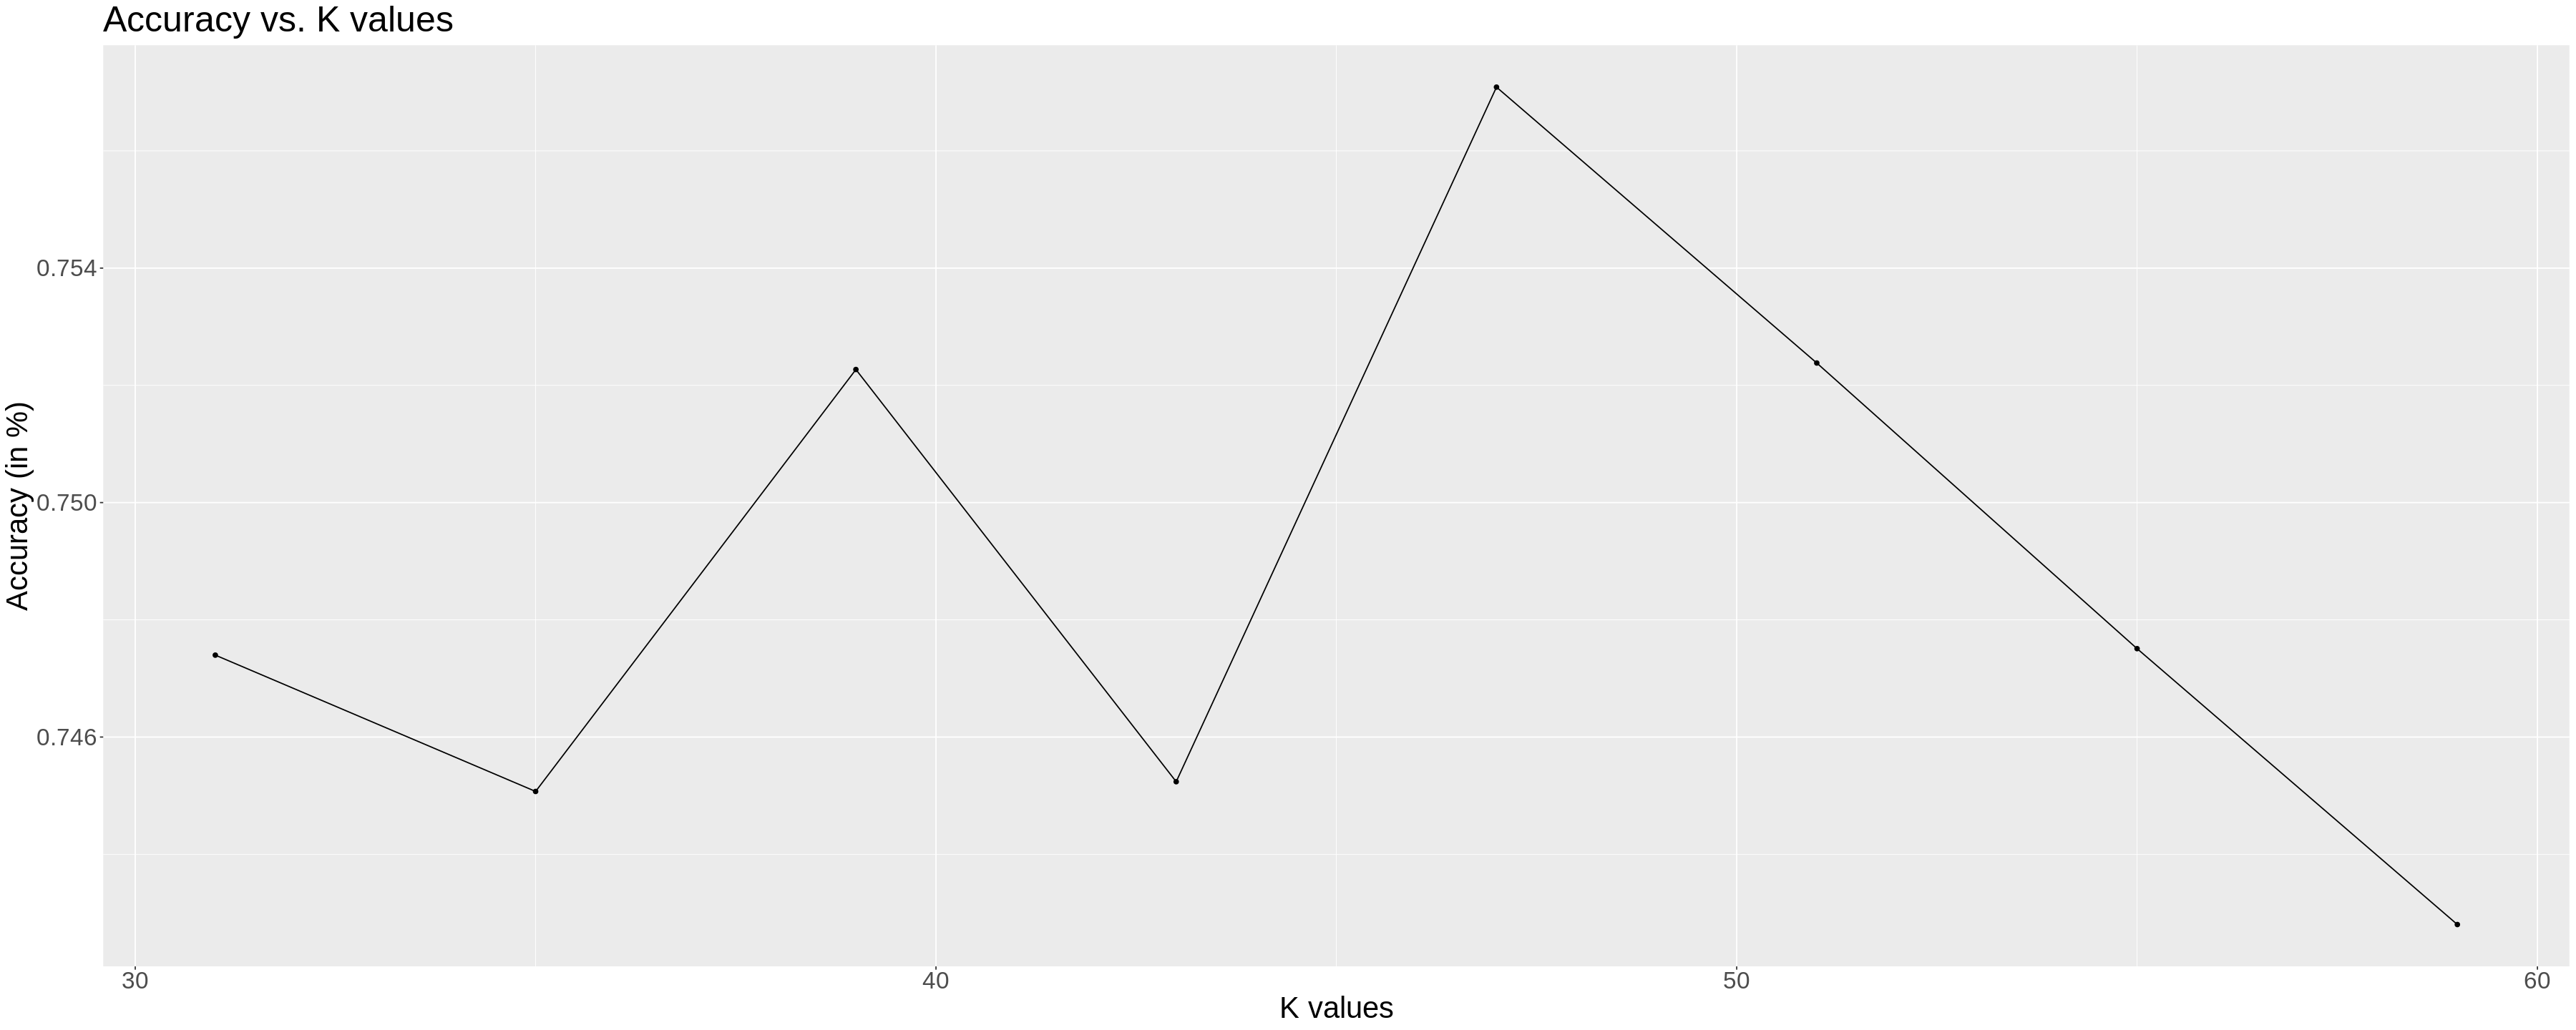

In [12]:
# Plotting K-plot for all-predictors model
all_kval_plot <- getKPlot(all_accuracy)
all_kval_plot

Using all five factors in the model leads to an unexpectedly decent accuracy. However, we will still check whether excluding any variable leads to a higher accuracy. The box plots above show that the IQR boxes entirely overlap for resting diastolic blood pressure, meaning there's weak/no correlation. Following this reasoning, our second model uses all variables except resting diastolic blood pressure.

In [41]:
set.seed(1337) # Set seed for reproducility

#creating recipe for model with all predictors except resting diastolic blood pressure
notrestbpd_recipe <- recipe(diagnosis ~ age + chol + thalach + thalrest, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#knn model with unknown K
notrestbpd_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating validation set and K values
notrestbpd_heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)
notrestbpd_k_vals <- tibble(neighbors = seq(from = 21, to = 61, by = 4))

#applying model to validation sets
notrestbpd_knn_results <- workflow() |>
    add_recipe(notrestbpd_recipe) |>
    add_model(notrestbpd_knn_spec) |>
    tune_grid(resamples = notrestbpd_heart_vfold, grid = notrestbpd_k_vals) |>
    collect_metrics()
 
#Getting K values accuracy
notrestbpd_accuracy <- notrestbpd_knn_results |>
    filter(.metric == "accuracy")

#Filtering for most accurate K value
notrestbpd_kvalue <- notrestbpd_accuracy |> filter(mean == max(mean)) 

#pulling the two values we want: the most accurate K and it's accuracy
pull(notrestbpd_kvalue, neighbors)
pull(notrestbpd_kvalue, mean)

[1] 53

[1] 0.7662237

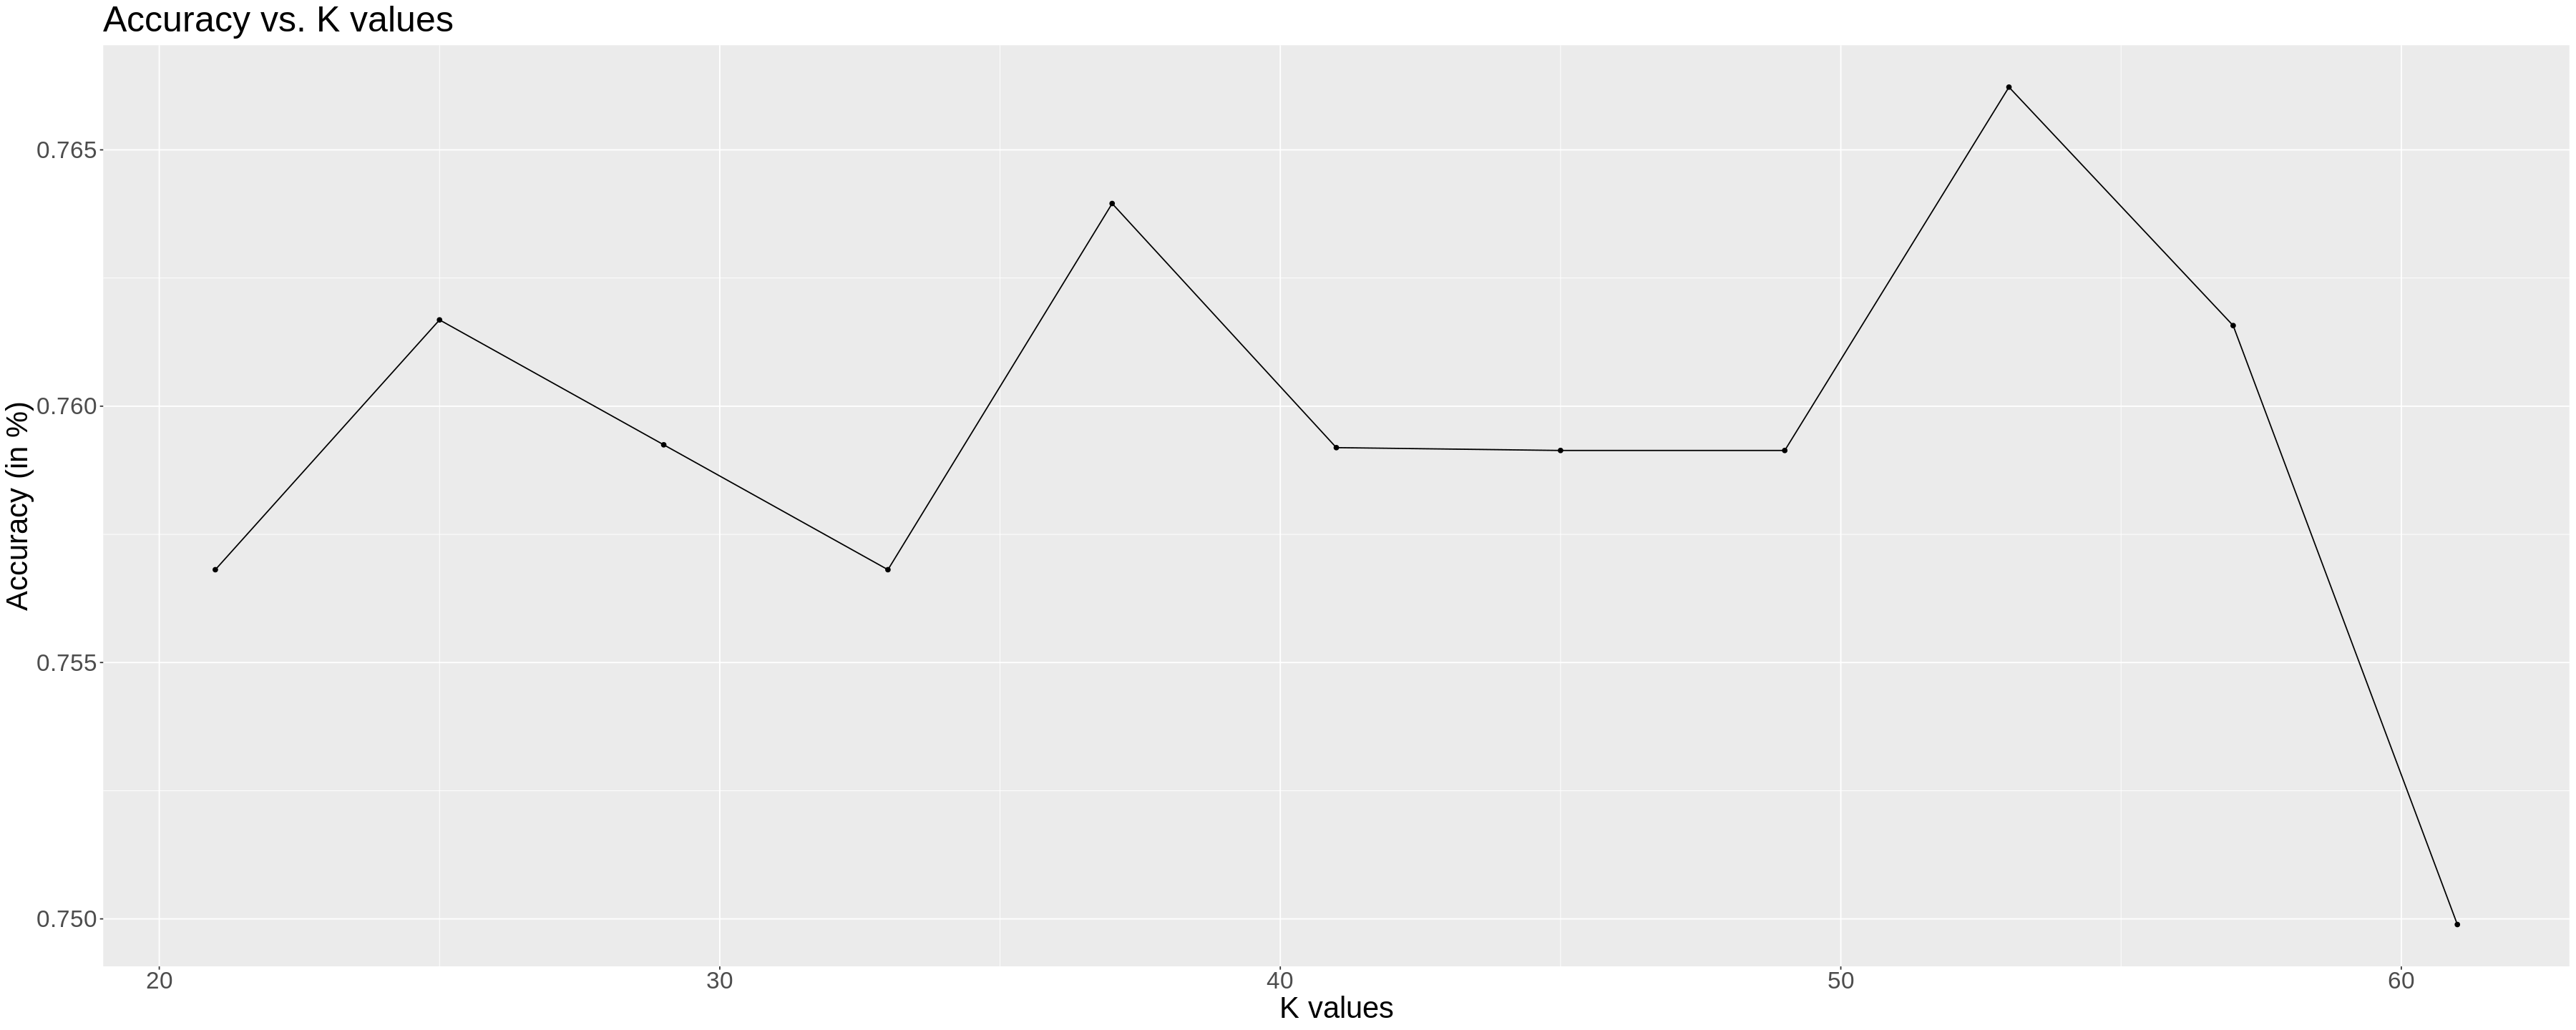

In [14]:
# Plotting K-plot for all-predictors except resting diastolic blood pressure model
notrestbpd_plot <- getKPlot(notrestbpd_accuracy)
notrestbpd_plot

The second model has a higher accuracy than the first. Following our previous logic, we will choose another variable to exclude in case the third model is better than the second. Serum cholesterol has the second weakest correlation since neither median is above or below the other diagnosis's IQR. Looking at where the medians are in comparison to the IQR is a way to estimate if there could be a significant difference between variables. 

In [42]:
set.seed(1337) # Set seed for reproducility

#creating recipe for model with age, resting heart rate and active heart rate
nobpd_chol_recipe <- recipe(diagnosis ~ age + thalach + thalrest, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#knn model with unknown K
nobpd_chol_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating validation set and K values
nobpd_chol_heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)
nobpd_chol_k_vals <- tibble(neighbors = seq(from = 31, to = 81, by = 4))

#applying model to validation sets
nobpd_chol_knn_results <- workflow() |>
    add_recipe(nobpd_chol_recipe) |>
    add_model(nobpd_chol_knn_spec) |>
    tune_grid(resamples = nobpd_chol_heart_vfold, grid = nobpd_chol_k_vals) |>
    collect_metrics()

#Getting K values accuracy
nobpd_chol_accuracy <- nobpd_chol_knn_results |>
    filter(.metric == "accuracy")

#Filtering for most accurate K value
nobpd_chol_kvalue <- nobpd_chol_accuracy |> filter(mean == max(mean)) 

#pulling the two values we want: the most accurate K and it's accuracy
pull(nobpd_chol_kvalue, neighbors)
pull(nobpd_chol_kvalue, mean)

[1] 51

[1] 0.7076966

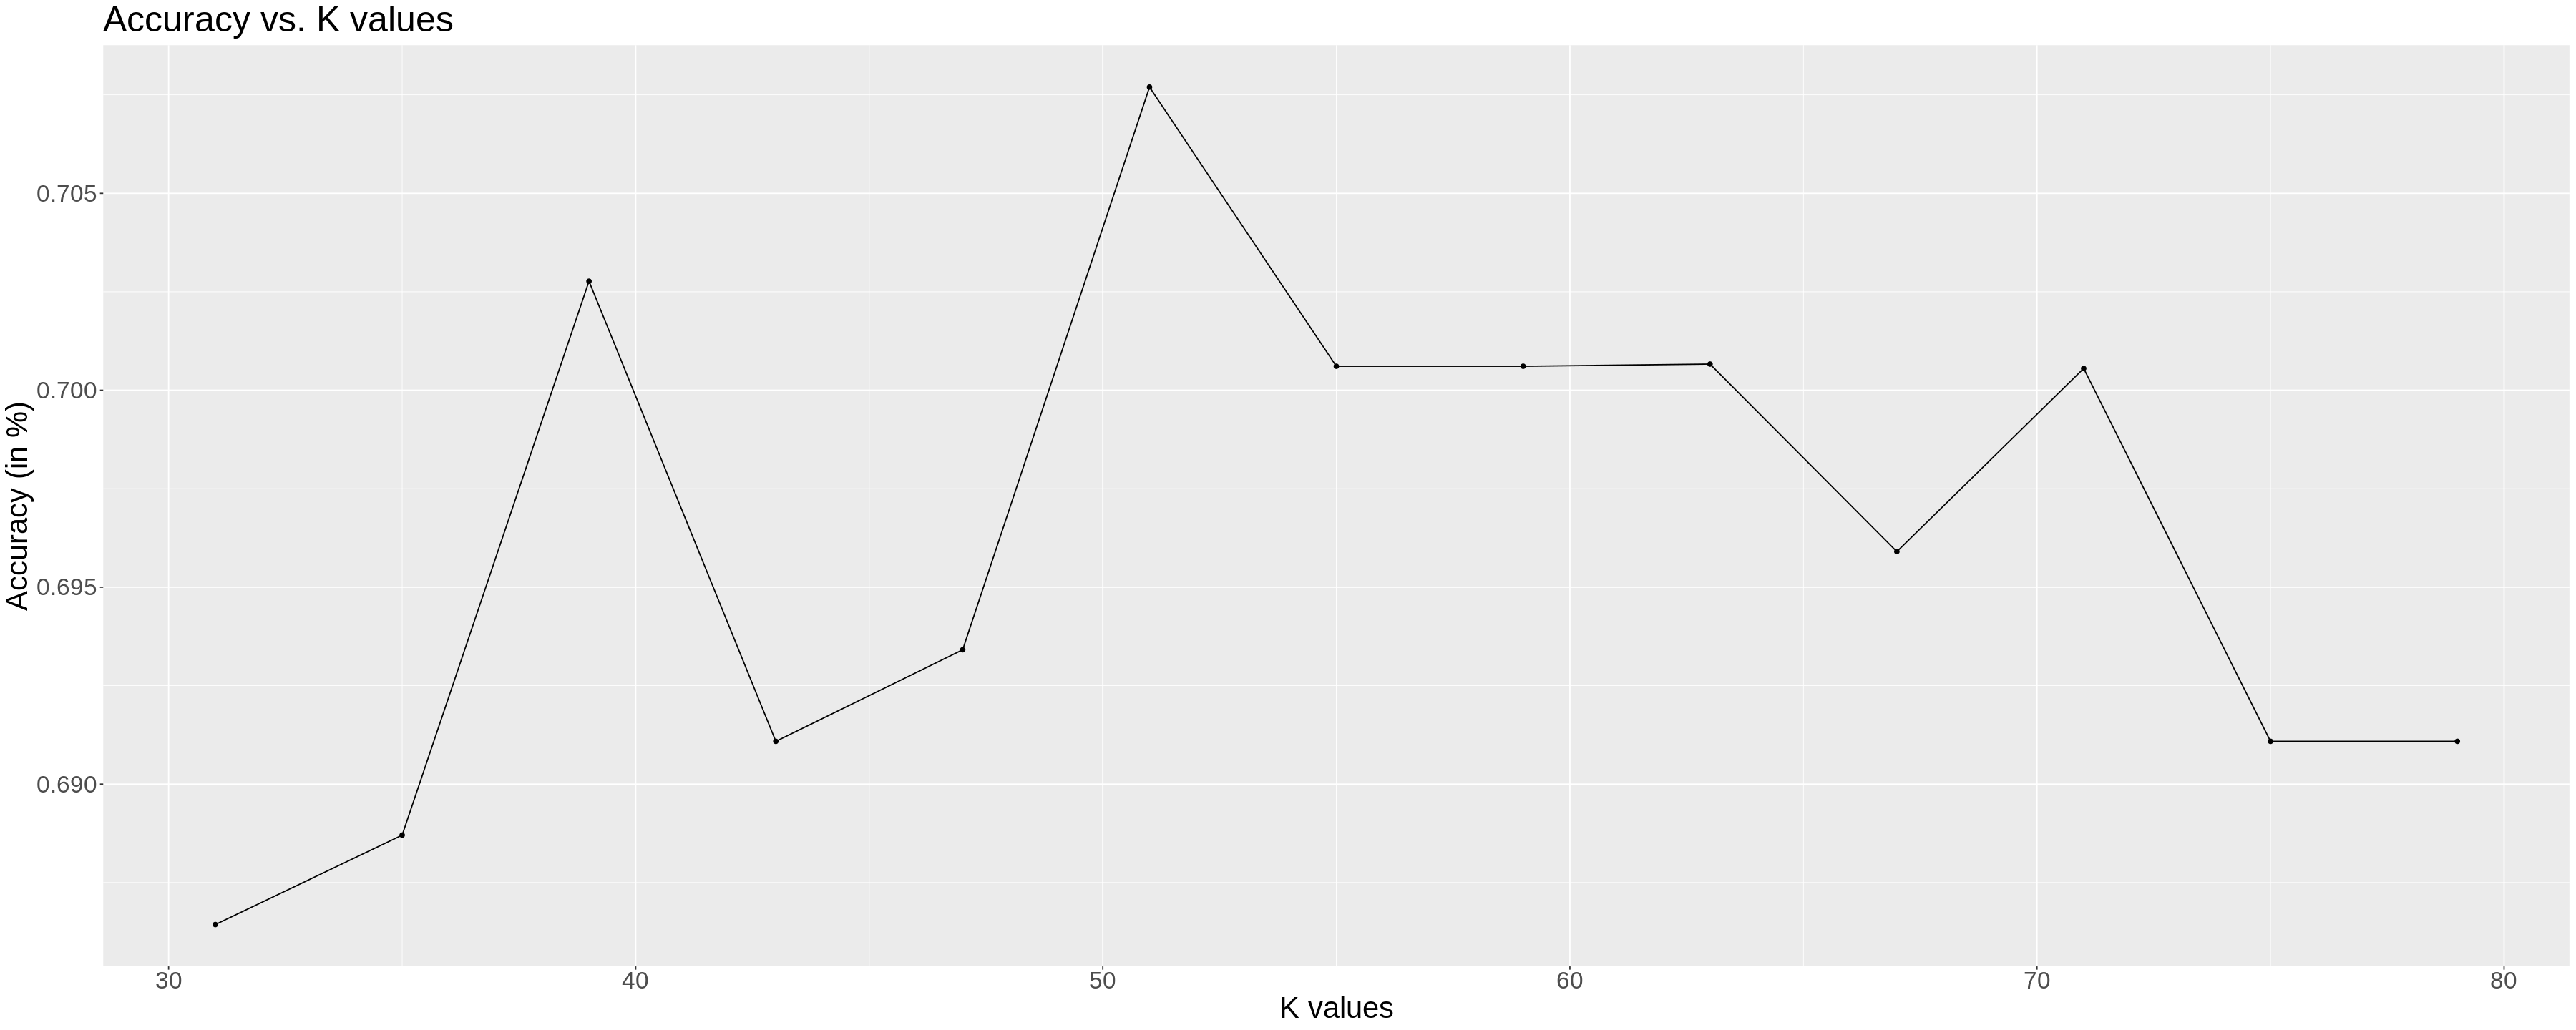

In [16]:
# Plotting K-plot for age, resting heart rate and active heart rate predictors model
nobpd_chol_plot <- getKPlot(nobpd_chol_accuracy)
nobpd_chol_plot

The third model has a lower accuracy than the first and second models, which makes our second model the most accurate. We used the testing set against the second model to see its accuracy against new data.

In [17]:
#Testing accuracy using the test set on best model: All except trestbpd with K=55

#Using known K value to make a knn model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 55) |>
  set_engine("kknn") |>
  set_mode("classification")

#remaking the best model with K=55
knn_fit <- workflow() |>
  add_recipe(notrestbpd_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)

#Testing model with test set
heart_test_predictions <- predict(knn_fit, heart_test) |>
  bind_cols(heart_test) 
 
#Getting the accuracy of the model
heart_accuracy <- heart_test_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

#Creating a confusion matrix
confusion <- heart_test_predictions |>
             conf_mat(truth = diagnosis, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 26 19
         1 16 46

## 2.3 Visualization of Classification Model

First, we must convert the confusion matrix to a data frame and calculate the percentage for true positive, true negative, false positive and false negative.

In [18]:
# Convert confusion matrix to a dataframe
confusion_df <- as.data.frame(confusion$table) |>
    mutate(Percentage = Freq / sum(Freq))
confusion_df

Prediction,Truth,Freq,Percentage
<fct>,<fct>,<dbl>,<dbl>
0,0,26,0.2429907
1,0,16,0.1495327
0,1,19,0.1775701
1,1,46,0.4299065


Next, we will use a heatmap to depict the percentage of the following:

    - True positive - when the prediction and the truth are both 1
    - True negative - when the prediction and the truth are both 0
    - False positive - when the prediction is 1, and the truth is 0
    - False negative - when the prediction is 0, and the truth is 1


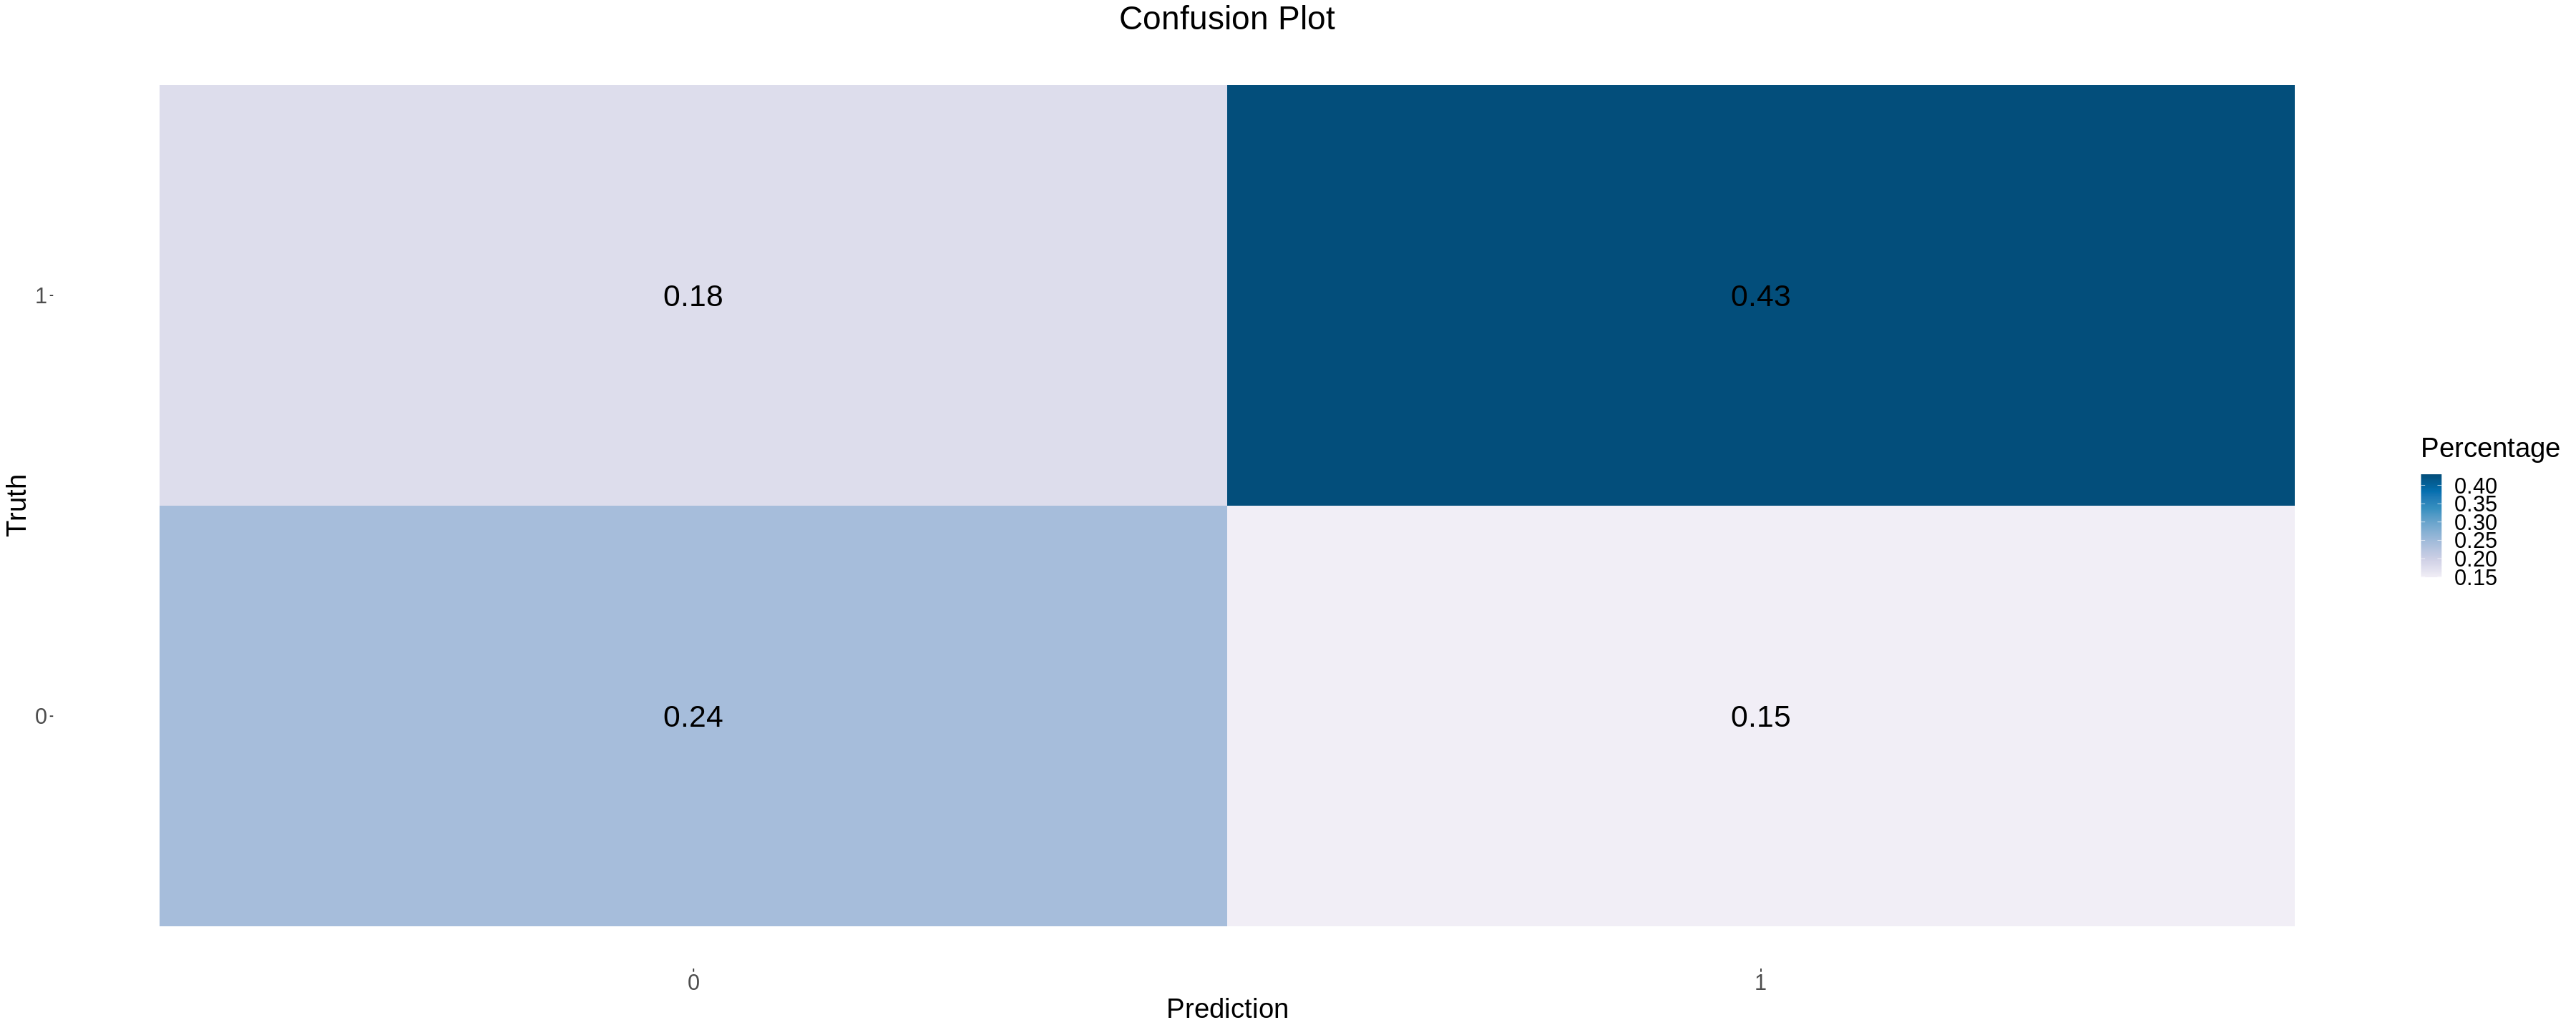

In [74]:
#creating the confusion plot
confusion_plot <- confusion_df |>
    ggplot(aes(x = Prediction, y = Truth, fill = Percentage)) +
    geom_tile() +
    geom_text(size = 9, aes(label = round(Percentage, 2))) +
    scale_fill_distiller(palette = "PuBu", direction = 1) +
    theme_bw() +
    theme(panel.border = element_blank(), panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank()) +
    theme(text = element_text(size = 23), plot.title = element_text(hjust = 0.5)) +
    ggtitle("Confusion Plot")
confusion_plot

## 3. Discussion 

   In this project, our group conducted a data analysis investigating the key factors contributing to the risk of being diagnosed with heart disease. The predictors used were age, cholesterol, maximum and resting heart rate. The final visualization indicated that the model was correct about an individual having heart disease 43% of the time. The accuracy of predicting an individual not having heart disease was 24%. The combination results in a 67% accuracy for our model that utilizes four health factors. 

   Our model’s accuracy is lower than expected. According to Hajar (2017), old age and high cholesterol level is directly related to the incidence of heart disease, which is supported by the high correlation seen in our visualizations of preliminary exploratory data. Additionally, from our initial visualization, those with lower active and resting heart rates tend to be diagnosed with heart disease. Nonetheless, the 67% accuracy was surprising. The low accuracy may be due to the surface-level health information gathered, and they were not a detailed analysis of an individual’s health and lifestyle. For example, when we look at serum cholesterol levels, no information was mentioned regarding whether the measurement was taken for HDL or LDL cholesterol. Mentioning this is crucial since it is beneficial to have high levels of HDL cholesterol, but high levels of LDL cholesterol may harm your body, leading to a heart condition. 
On the logistical side of the model, the contribution of error could have been the imbalanced data. As we can see on the true negative column (bottom left) of our visualization, the accuracy of predicting a true negative is low. So, for future projects balancing the data and increasing the number of data of those that do not have heart disease could increase the overall accuracy of our data. 

   Nevertheless, these findings are significant because heart disease is a leading cause of death worldwide, as mentioned in the introduction. Therefore, understanding and identifying the modifiable risk factors associated with heart disease can help individuals take preventative measures to reduce their risk of developing the disease. A question that can be answered in future projects or research is what other health factors could play a more prominent role than those seen in the project. Ultimately, this could lead to finding the single most crucial factor that leads to the diagnosis of heart disease to run predictions. Also, physicians can look at what changes they can make to approach an individual’s situation regarding their high risk of getting heart disease. Is using highly advanced medications and methods always the most optimal way to treat or prevent heart disease? 


## References
Advocate , H. (2023). Ischemic heart disease: Advocate health care. Advocate Health. 
Retrieved March 10, 2023, from https://www.advocatehealth.com/health-services/advocate-heart-institute/conditions/ischemic-heart-disease#:~:text=Ischemic%20heart%20disease%20refers%20to,cardiac%20ischemia%20or%20ischemic%20cardiomyopathy.

Andras Janosi, M.D. (1988) Heart Disease Data Set. UCI Machine Learning Repository. 
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Center for Disease Control and Prevention. (2020, April 21). Prevent heart disease. Centers for 
Disease Control and Prevention. Retrieved March 10, 2023, from https://www.cdc.gov/heartdisease/prevention.htm#print

Hajar R. (2017). Risk Factors for Coronary Artery Disease: Historical Perspectives. Heart views: 
the official journal of the Gulf Heart Association, 18(3), 109–114. https://doi.org/10.4103/HEARTVIEWS.HEARTVIEWS_106_17

Olvera Lopez E, Ballard BD, Jan A. Cardiovascular Disease. [Updated 2022 Aug 8]. In: 
StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2022 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK535419/

Public Health Agency of Canada. (2018). Report from the Canadian Chronic Disease 
Surveillance System: Heart Disease in Canada, 2018. Retrieved from the Government of Canada website: https://www.canada.ca/content/dam/phac-aspc/documents/services/publications/diseases-conditions/report-heart-disease-canada-2018/pub1-eng.pdf